Step 1: Install Libraries

In [ ]:
# Cell 1: Install Libraries
##!pip install tensorflow pandas numpy scikit-learn matplotlib tcn

Step 2: Import Dependencies

In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tcn import TCN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.15.0


Step 3:Load, Prepare, and Engineer Features

In [4]:
# --- Configuration ---
DATASET_PATH = "dataset.csv"
TARGET_VARIABLE = 'soil_moisture'

# --- Load Data ---
try:
    df = pd.read_csv(DATASET_PATH)
except FileNotFoundError:
    print(f"Error: The file '{DATASET_PATH}' was not found.")

# --- Preprocessing ---
# Convert 'timestamp' to datetime and set as index
try:
    df['timestamp'] = pd.to_datetime(df['timestamp'], dayfirst=True)
except Exception as e:
    print(f"An error occurred during date conversion: {e}")
    print("Attempting to infer format automatically...")
    df['timestamp'] = pd.to_datetime(df['timestamp'], infer_datetime_format=True)

df.set_index('timestamp', inplace=True)
df.sort_index(inplace=True)

# --- Feature Engineering ---
print("Applying feature engineering...")
# Create cyclical features for the hour of the day
df['hour'] = df.index.hour
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

# Create an interaction feature
df['temp_humidity_interaction'] = df['ambient_temp'] * df['ambient_hum']
df.drop('hour', axis=1, inplace=True) # Drop the original hour column

# 6 original features plus the 3 new engineered features.
MODEL_FEATURES = [
    'soil_moisture', 'soil_temp', 'ec', 'ph', 'ambient_temp', 'ambient_hum',
    'hour_sin', 'hour_cos', 'temp_humidity_interaction'
]

# Select only the features we need for the model
df_model = df[MODEL_FEATURES]

# Handle missing values
df_model.ffill(inplace=True)
df_model.bfill(inplace=True)

print("\nData Head (with new features):")
print(df_model.head())
print("\nData Info:")
df_model.info()
print(f"\nDataset shape: {df_model.shape}")

Applying feature engineering...

Data Head (with new features):
                     soil_moisture  soil_temp       ec     ph  ambient_temp  \
timestamp                                                                     
2024-01-01 00:00:00         60.000     21.000  500.000  7.000        13.458   
2024-01-01 00:20:00         59.987     20.863  504.467  7.004        12.870   
2024-01-01 00:40:00         59.973     20.772  505.980  6.994        12.830   
2024-01-01 01:00:00         59.973     20.653  504.427  7.021        12.308   
2024-01-01 01:20:00         59.973     20.472  504.997  7.029        11.077   

                     ambient_hum  hour_sin  hour_cos  \
timestamp                                              
2024-01-01 00:00:00       99.388  0.000000  1.000000   
2024-01-01 00:20:00       98.905  0.000000  1.000000   
2024-01-01 00:40:00       98.757  0.000000  1.000000   
2024-01-01 01:00:00      100.000  0.258819  0.965926   
2024-01-01 01:20:00      100.000  0.258819  0.

Step 4: Visualize Time Series Data

Plotting the time series data...


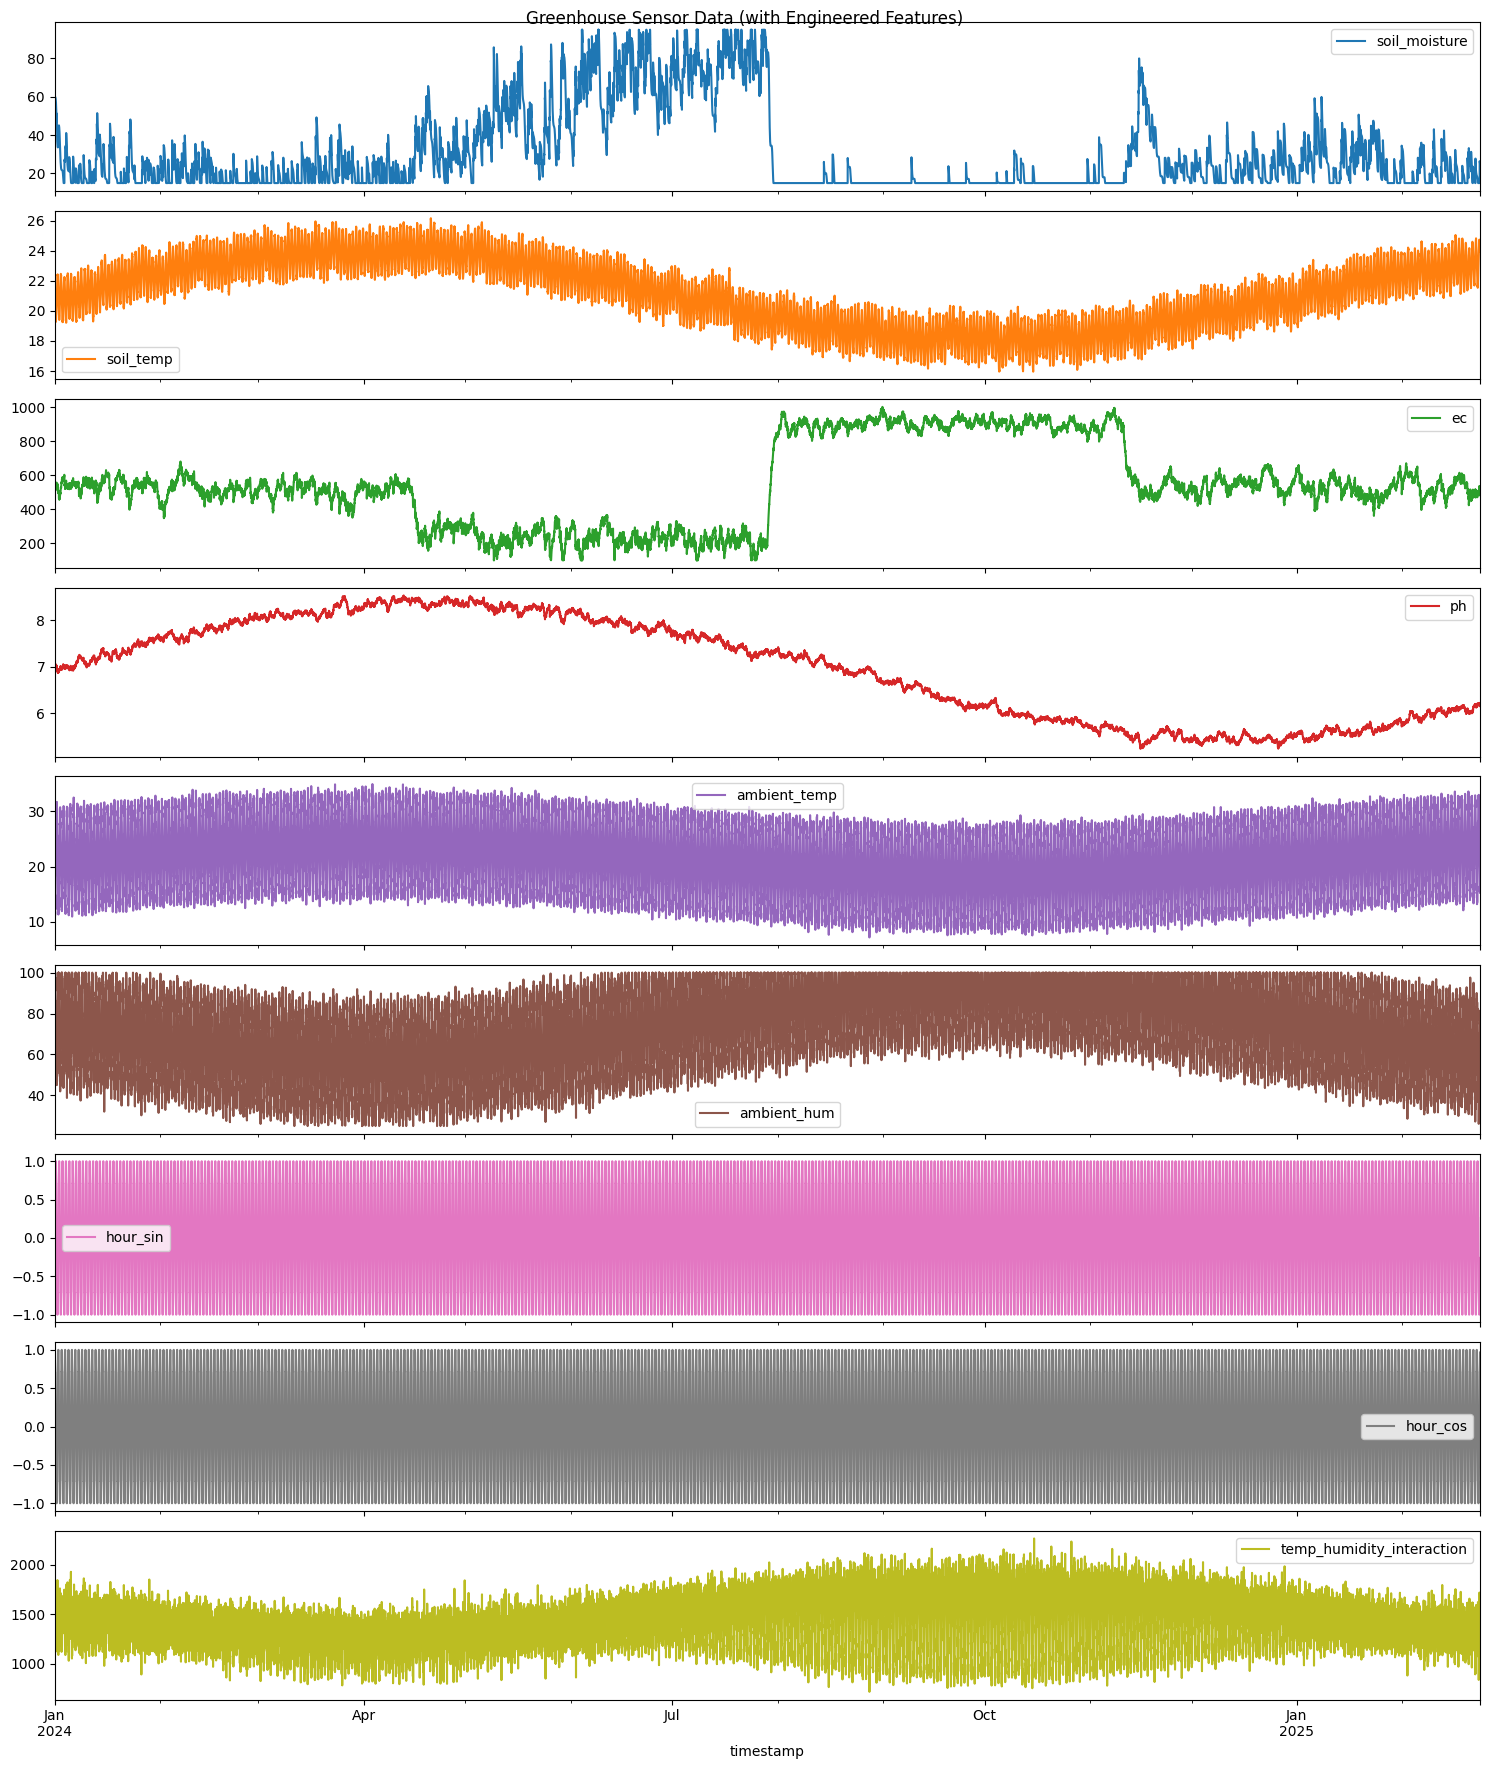

In [5]:
print("Plotting the time series data...")
df_model.plot(subplots=True, figsize=(15, 18), title="Greenhouse Sensor Data (with Engineered Features)")
plt.tight_layout()
plt.show()

Step 5: Data Splitting & Scaling

In [6]:
# --- Chronological Split ---
train_size = int(len(df_model) * 0.7)
val_size = int(len(df_model) * 0.15)

train_df = df_model.iloc[:train_size]
val_df = df_model.iloc[train_size:train_size + val_size]
test_df = df_model.iloc[train_size + val_size:]

print(f"Training set shape:   {train_df.shape}")
print(f"Validation set shape: {val_df.shape}")
print(f"Test set shape:       {test_df.shape}")

# --- Scaling ---
scaler = MinMaxScaler()
scaler.fit(train_df)

train_scaled = scaler.transform(train_df)
val_scaled = scaler.transform(val_df)
test_scaled = scaler.transform(test_df)

target_scaler = MinMaxScaler()
target_scaler.fit(train_df[[TARGET_VARIABLE]])

Training set shape:   (21168, 9)
Validation set shape: (4536, 9)
Test set shape:       (4536, 9)


,feature_range,"(0, ...)"
,copy,True
,clip,False


Step 6: Create Windowed Datasets

In [7]:
def create_dataset(data, window_size=24, target_index=0):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size, target_index])
    return np.array(X), np.array(y)

WINDOW_SIZE = 24
TARGET_COLUMN_INDEX = df_model.columns.get_loc(TARGET_VARIABLE)

X_train, y_train = create_dataset(train_scaled, WINDOW_SIZE, TARGET_COLUMN_INDEX)
X_val, y_val = create_dataset(val_scaled, WINDOW_SIZE, TARGET_COLUMN_INDEX)
X_test, y_test = create_dataset(test_scaled, WINDOW_SIZE, TARGET_COLUMN_INDEX)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_val:   {X_val.shape}")
print(f"Shape of y_val:   {y_val.shape}")
print(f"Shape of X_test:  {X_test.shape}")
print(f"Shape of y_test:  {y_test.shape}")

Shape of X_train: (21144, 24, 9)
Shape of y_train: (21144,)
Shape of X_val:   (4512, 24, 9)
Shape of y_val:   (4512,)
Shape of X_test:  (4512, 24, 9)
Shape of y_test:  (4512,)


Step 7: Build Lightweight TCN Model

In [8]:
# --- Model Hyperparameters ---
TCN_FILTERS = 24
KERNEL_SIZE = 3
DILATIONS = [1, 2, 4]
NUM_FEATURES = X_train.shape[2] # This will now correctly be 9

# --- Define TCN Model ---
model = Sequential([
    TCN(
        input_shape=(WINDOW_SIZE, NUM_FEATURES),
        nb_filters=TCN_FILTERS,
        kernel_size=KERNEL_SIZE,
        dilations=DILATIONS,
        padding='causal',
        use_skip_connections=True,
        dropout_rate=0.1,
        return_sequences=False
    ),
    Dense(1)
])

# --- Compile Model ---
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)

model.summary()

2025-08-25 20:47:39.815685: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2025-08-25 20:47:39.815714: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-08-25 20:47:39.815723: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2025-08-25 20:47:39.815795: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-08-25 20:47:39.815846: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn (TCN)                   (None, 24)                9672      
                                                                 
 dense (Dense)               (None, 1)                 25        
                                                                 
Total params: 9697 (37.88 KB)
Trainable params: 9697 (37.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Step 8: Train the Model

Epoch 1/100


2025-08-25 20:47:50.644314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-08-25 20:47:50.711859: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


331/331 [==============================] - 8s 21ms/step - loss: 0.0845 - mean_absolute_error: 0.1235 - val_loss: 0.0026 - val_mean_absolute_error: 0.0382
Epoch 2/100
331/331 [==============================] - 7s 20ms/step - loss: 0.0037 - mean_absolute_error: 0.0463 - val_loss: 0.0024 - val_mean_absolute_error: 0.0370
Epoch 3/100
331/331 [==============================] - 7s 20ms/step - loss: 0.0021 - mean_absolute_error: 0.0335 - val_loss: 0.0023 - val_mean_absolute_error: 0.0338
Epoch 4/100
331/331 [==============================] - 6s 18ms/step - loss: 0.0016 - mean_absolute_error: 0.0280 - val_loss: 0.0017 - val_mean_absolute_error: 0.0286
Epoch 5/100
331/331 [==============================] - 6s 19ms/step - loss: 0.0012 - mean_absolute_error: 0.0244 - val_loss: 0.0013 - val_mean_absolute_error: 0.0232
Epoch 6/100
331/331 [==============================] - 6s 19ms/step - loss: 0.0010 - mean_absolute_error: 0.0215 - val_loss: 0.0013 - val_mean_absolute_error: 0.0248
Epoch 7/100
331/

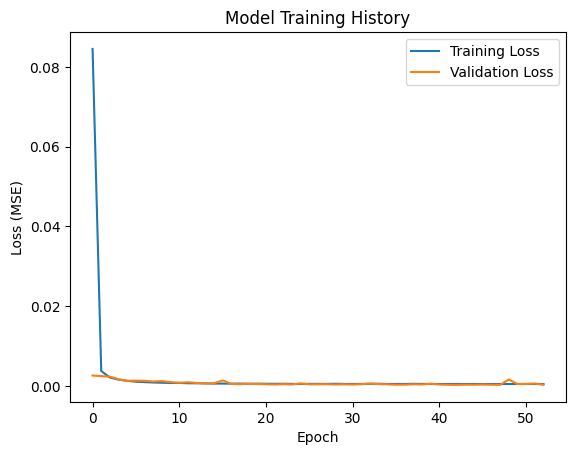

In [9]:
# --- Callbacks ---
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# --- Training ---
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# --- Plot Training History ---
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.savefig('training_history.png')
plt.show()

Step 9: Evaluate the Model

141/141 [==============================] - 1s 8ms/step
--- Model Evaluation on Test Set ---
R-squared (R²): 0.9673
Mean Absolute Error (MAE): 0.5417


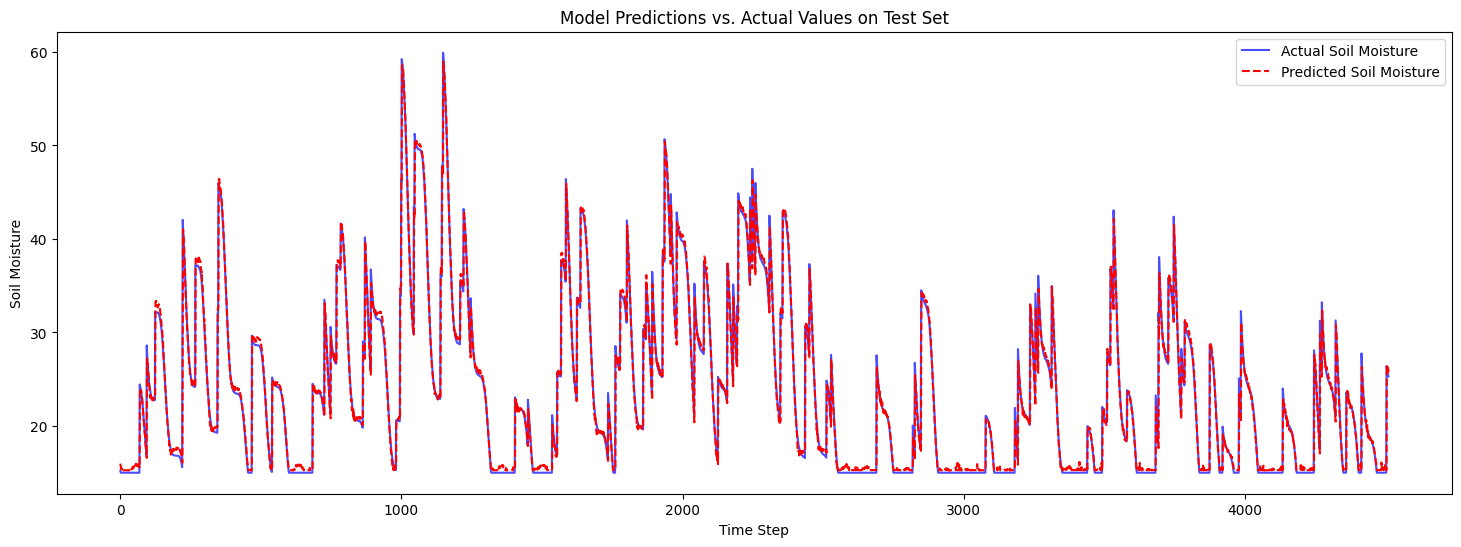

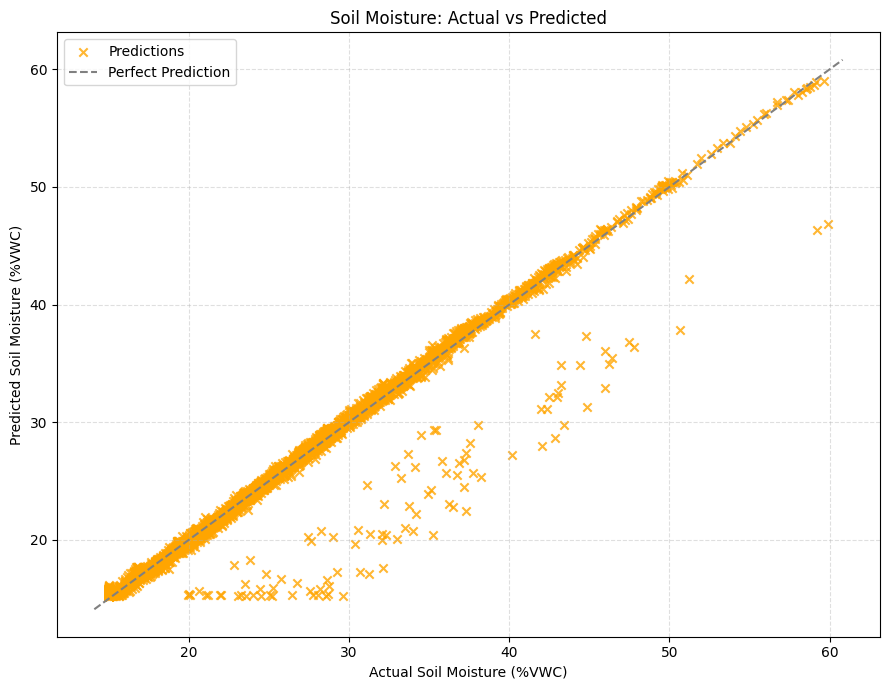

In [10]:
# --- Make Predictions on the Test Set ---
y_pred_scaled = model.predict(X_test)

# --- Inverse Transform to Original Scale ---
y_test_reshaped = y_test.reshape(-1, 1)
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_true = target_scaler.inverse_transform(y_test_reshaped)

# --- Calculate Metrics ---
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

print("--- Model Evaluation on Test Set ---")
print(f"R-squared (R²): {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# --- Visualize Predictions vs. Actual Values ---
plt.figure(figsize=(18, 6))
plt.plot(y_true, label='Actual Soil Moisture', color='blue', alpha=0.7)
plt.plot(y_pred, label='Predicted Soil Moisture', color='red', linestyle='--')
plt.title('Model Predictions vs. Actual Values on Test Set')
plt.xlabel('Time Step')
plt.ylabel('Soil Moisture')
plt.legend()
plt.savefig('Soil_Moisture_Actual_vs_Predicted1.png', dpi=300)
plt.show()

# --- Visualize Predictions vs. Actual Values (Time Series Plot) ---
# Flatten in case y_true / y_pred are shape (N, 1)
y_true_flat = np.ravel(y_true)
y_pred_flat = np.ravel(y_pred)

# Range for diagonal reference line
vmin = float(min(y_true_flat.min(), y_pred_flat.min()))
vmax = float(max(y_true_flat.max(), y_pred_flat.max()))
pad = 0.02 * (vmax - vmin)

plt.figure(figsize=(9, 7))
plt.scatter(y_true_flat, y_pred_flat, marker='x', alpha=0.8,
            label='Predictions', color='orange')
plt.plot([vmin - pad, vmax + pad], [vmin - pad, vmax + pad],
         linestyle='--', color='gray', label='Perfect Prediction')

plt.title('Soil Moisture: Actual vs Predicted')
plt.xlabel('Actual Soil Moisture (%VWC)')
plt.ylabel('Predicted Soil Moisture (%VWC)')
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('Soil_Moisture_Actual_vs_Predicted2.png', dpi=300)
plt.show()




Step 10: Convert to TensorFlow Lite (Quantized)

In [11]:
# --- Create a Representative Dataset for Quantization ---
def representative_dataset_gen():
    for i in range(100):
        yield [X_train[i:i+1].astype(np.float32)]

# --- Convert the Model ---
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model_quant = converter.convert()

# --- Save the Quantized Model ---
TFLITE_MODEL_PATH = "tcn_model_quant_9_features.tflite"
with open(TFLITE_MODEL_PATH, 'wb') as f:
    f.write(tflite_model_quant)

print(f"Quantized TFLite model saved to: {TFLITE_MODEL_PATH}")

# --- Compare Model Sizes ---
keras_model_size = os.path.getsize('best_model.h5') if os.path.exists('best_model.h5') else 0
tflite_model_size = os.path.getsize(TFLITE_MODEL_PATH)

print(f"\nSize of original Keras model: {keras_model_size / 1024:.2f} KB")
print(f"Size of quantized TFLite model: {tflite_model_size / 1024:.2f} KB")
if keras_model_size > 0:
    print(f"Reduction: {100 * (1 - tflite_model_size / keras_model_size):.2f}%")

INFO:tensorflow:Assets written to: /var/folders/pz/mz72ytmd1qd6jpy_4wjl15wr0000gn/T/tmpg69tz8yn/assets


INFO:tensorflow:Assets written to: /var/folders/pz/mz72ytmd1qd6jpy_4wjl15wr0000gn/T/tmpg69tz8yn/assets
/Users/jd/Documents/irrigation-model_best/venv/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2025-08-25 20:57:16.030237: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2025-08-25 20:57:16.030248: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2025-08-25 20:57:16.030644: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/pz/mz72ytmd1qd6jpy_4wjl15wr0000gn/T/tmpg69tz8yn
2025-08-25 20:57:16.032220: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2025-08-25 20:57:16.032225: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/pz/mz72ytmd

Quantized TFLite model saved to: tcn_model_quant_9_features.tflite

Size of original Keras model: 0.00 KB
Size of quantized TFLite model: 31.27 KB


Step 11: Convert TFLite Model to a C Header File

In [12]:
# --- Configuration for C array ---
MODEL_TFLITE = TFLITE_MODEL_PATH
MODEL_HEADER = 'tcn_model.h'
ARRAY_NAME = 'g_tcn_model_data'

# --- Use xxd to generate the C header ---
os.system(f"xxd -i {MODEL_TFLITE} > {MODEL_HEADER}")

# --- Optional: Add 'const' and 'alignas(16)' for MCU optimization ---
with open(MODEL_HEADER, 'r') as f:
    content = f.read()
new_declaration = f"const unsigned char {ARRAY_NAME}[] __attribute__((aligned(16))) = {{"
content = content.replace(f"unsigned char {MODEL_TFLITE.replace('.', '_')}[] = {{", new_declaration)
with open(MODEL_HEADER, 'w') as f:
    f.write(content)

print(f"\nC header file '{MODEL_HEADER}' created successfully.")



C header file 'tcn_model.h' created successfully.


In [15]:
# --- Scaling ---
scaler = MinMaxScaler()
scaler.fit(train_df)

# Add these lines for C-style array output
print("\n// Copy these arrays into your Arduino sketch")
print("const float feature_min[NUM_FEATURES] = {")
print(','.join([f'    {val:.6f}f' for val in scaler.data_min_]))
print("};")

print("\nconst float feature_max[NUM_FEATURES] = {")
print(','.join([f'    {val:.6f}f' for val in scaler.data_max_]))
print("};")
# --- End of added lines ---

train_scaled = scaler.transform(train_df)
val_scaled = scaler.transform(val_df)
test_scaled = scaler.transform(test_df)


// Copy these arrays into your Arduino sketch
const float feature_min[NUM_FEATURES] = {
    15.000000f,    15.956000f,    100.000000f,    5.762000f,    7.154000f,    25.000000f,    -1.000000f,    -1.000000f,    715.400000f
};

const float feature_max[NUM_FEATURES] = {
    95.000000f,    26.169000f,    1001.453000f,    8.533000f,    34.976000f,    100.000000f,    1.000000f,    1.000000f,    2267.493150f
};
